# Bank Loan Prediction
> "Relationship managers at a bank who operate in the small business segment have a large customer portfolio. Because of this, he/she can currently only reactively serve customers. The current experiment is set up to look for solutions that can help the relationship manager to more proactively serve his customers."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Ashish Kashav
- categories: [jupyter]

# Installations

In [ ]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from boruta import BorutaPy
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from hyperopt import space_eval
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")
import shap
shap.initjs()

# Data preprocessing and EDA

In [ ]:
credit=pd.read_csv("credit_applications.csv")

In [ ]:
cust=pd.read_csv("customers.csv")

In [ ]:
cust.head()

,Unnamed: 0,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG
0,1,1,201401,97,50,6527929,47,7454863,-7914288,25110651,1.0
1,2,1,201402,88,59,3475918,29,1895848,-8448513,25036651,1.0
2,3,1,201403,96,62,31316405,34,20083583,-10347650,18020151,1.0
3,4,1,201404,83,53,18669967,30,1091295,-15385039,13318200,1.0
4,5,1,201405,94,54,2893905,40,2034075,-15682170,2350000,1.0


In [ ]:
cust.drop(['Unnamed: 0','client_nr','yearmonth','CRG'],axis=1).describe()

,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance
count,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04
mean,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06
std,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08
25%,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06
50%,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06
75%,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06
max,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08


some extreme values prsent for transactional behavior

In [ ]:
cust.isna().sum()

Unnamed: 0              0
client_nr               0
yearmonth               0
total_nr_trx            0
nr_debit_trx            0
volume_debit_trx        0
nr_credit_trx           0
volume_credit_trx       0
min_balance             0
max_balance             0
CRG                  5537
dtype: int64

seems like Credit risk group variable have some missing values. Instead of dropping or filling with the mode we shall assign a different category to them.

In [ ]:
cust.groupby(['client_nr'])['yearmonth'].nunique().describe()

count    992.000000
mean      30.237903
std        5.742178
min        1.000000
25%       32.000000
50%       32.000000
75%       32.000000
max       32.000000
Name: yearmonth, dtype: float64

this show some clients do not have full time series. We can drop those clients but we can keep as well, its a subjective choice.

In [ ]:
#rows=cust.groupby(['client_nr'])['yearmonth'].nunique().reset_index().rename(columns={'yearmonth':'row_counts'})

In [ ]:
#cust=cust.merge(rows,on='client_nr')

In [ ]:
#full=full[full['row_counts']==32]

In [ ]:
full=cust.drop("Unnamed: 0",axis=1).merge(credit.drop("Unnamed: 0",axis=1),on=['yearmonth','client_nr'])

In [ ]:
full['Date']=pd.to_datetime(full['yearmonth'].astype(str), format='%Y%m')

In [ ]:
max(full['Date'])

Timestamp('2016-08-01 00:00:00')

In [ ]:
min(full['Date'])

Timestamp('2014-01-01 00:00:00')

In [ ]:
full.groupby('Date')['nr_credit_applications'].sum().reset_index().sort_values(by='nr_credit_applications',ascending=False)

,Date,nr_credit_applications
18,2015-07-01,120
17,2015-06-01,120
21,2015-10-01,99
11,2014-12-01,96
4,2014-05-01,96
8,2014-09-01,96
5,2014-06-01,91
6,2014-07-01,89
16,2015-05-01,88
22,2015-11-01,87


In [ ]:
full=full.sort_values(by=['client_nr','Date'])

In [ ]:
full['month']=pd.DatetimeIndex(full['Date']).month

In [ ]:
full['month']=full['month'].astype('category')

In [ ]:
full.groupby('month')['nr_credit_applications'].sum().reset_index().sort_values(by='nr_credit_applications',ascending=False)

,month,nr_credit_applications
5,6,289
6,7,268
4,5,265
2,3,236
0,1,231
3,4,229
7,8,193
1,2,186
9,10,186
8,9,178


generally we see that from august there is a drop in applications of loans. so we can use the variable month as it can be useful.

In [ ]:
full['cash_flow']=full['volume_credit_trx']-full['volume_debit_trx']

we also caculate a feature called cash flow which define the net earnings of the clients for that timestamp and which keeps on getting accumalated.

In [ ]:
full.drop(['yearmonth'],axis=1,inplace=True)

In [ ]:
full['month']=full['month'].astype(str)

In [ ]:
full['CRG']=full['CRG'].astype('category')
full['CRG'].unique()

[1.0, 4.0, 7.0, 2.0, 3.0, 5.0, NaN]
Categories (6, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 7.0]

In [ ]:
full['CRG'] = full['CRG'].cat.add_categories(-1)
full['CRG'].fillna(-1, inplace=True)

## we also try to inspect how crg groups behave differently for different transactions dimensions.

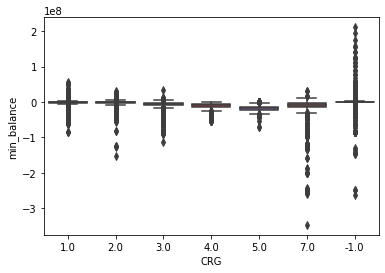

In [ ]:
sns.boxplot(x='CRG',y='min_balance',data=full)

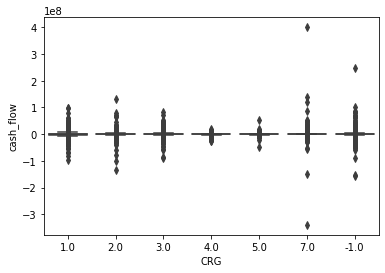

In [ ]:
sns.boxplot(x='CRG',y='cash_flow',data=full)

In [ ]:
full.groupby('CRG')['client_nr'].nunique().reset_index().sort_values(by='client_nr',ascending=False)

,CRG,client_nr
2,3.0,291
6,-1.0,194
0,1.0,140
5,7.0,138
1,2.0,136
3,4.0,68
4,5.0,25


In [ ]:
full.groupby('CRG')['nr_credit_applications'].sum().reset_index().sort_values(by='nr_credit_applications',ascending=False)

,CRG,nr_credit_applications
2,3.0,756
5,7.0,614
1,2.0,415
3,4.0,290
6,-1.0,217
0,1.0,186
4,5.0,134


there is good amount of variation with respect to the column crg so it is worthwile to keep the variable. on a general level it might be the case that the crg group 3 must be more trustable as compared to group 7.

In [ ]:
diff=full[full['credit_application']==1]

In [ ]:
diff['Prev']=diff.groupby('client_nr')['Date'].shift(1)

In [ ]:
diff=diff[['client_nr','Date','Prev']].fillna('2014-01-01')

In [ ]:
diff['consec']=(diff['Date']-diff['Prev'])// np.timedelta64(1, 'M')

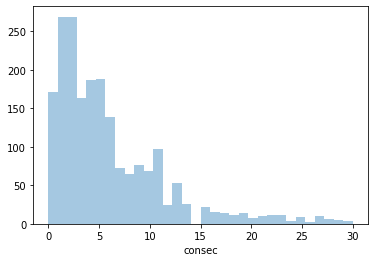

In [ ]:
sns.distplot(diff['consec'],kde=False)

In [ ]:
diff.head()

,client_nr,Date,Prev,consec
70,3,2014-07-01,2014-01-01,5
81,3,2015-06-01,2014-07-01,11
87,3,2015-12-01,2015-06-01,6
95,3,2016-08-01,2015-12-01,8
126,4,2016-07-01,2014-01-01,29


In [ ]:
diff['consec'].describe()

count    2025.000000
mean        5.841975
std         5.668782
min         0.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        30.000000
Name: consec, dtype: float64

from above we see that generally different between consective loans can be generally around 8 months. This information is useful to decide for the forecasting window that we should choose.

In [ ]:
full['avg_local_credit']=full['volume_credit_trx']/full['nr_credit_trx']
full['avg_local_debit']=full['volume_debit_trx']/full['nr_debit_trx']

In [ ]:
full['nr_credit_applications_cumsum']=full.groupby('client_nr')['nr_credit_applications'].cumsum()

In [ ]:
full['cash_flow_cumsum']=full.groupby('client_nr')['cash_flow'].cumsum()

In [ ]:
full['nr_debit_trx_cumsum']=full.groupby('client_nr')['nr_debit_trx'].cumsum()
full['nr_credit_trx_cumsum']=full.groupby('client_nr')['nr_credit_trx'].cumsum()

In [ ]:
full['volume_debit_trx_cumsum']=full.groupby('client_nr')['volume_debit_trx'].cumsum()
full['volume_credit_trx_cumsum']=full.groupby('client_nr')['volume_credit_trx'].cumsum()
full['avg_global_credit']=full['volume_credit_trx_cumsum']/full['nr_credit_trx_cumsum']
full['avg_global_debit']=full['volume_debit_trx_cumsum']/full['nr_debit_trx_cumsum']

In [ ]:
full['global_min_balance']=full.groupby('client_nr')['min_balance'].cummin()

In [ ]:
full['global_max_balance']=full.groupby('client_nr')['max_balance'].cummax()

In [ ]:
def create_shifted_lables(data,n):
    data['T+'+str(n)+'_nr_credit_applications']=data.groupby('client_nr')['nr_credit_applications'].shift(-n)

we calcalate some variables as above on a cumulative value so that at each time stamp we can also have historical information with use which will help us in predicting the future actions of the clients.

In [ ]:
for i in range(1,13):
  create_shifted_lables(full,i)

we manipulate data to create target variable such as number of loans taken in the future at t+n timestamp which will be use to predict.

In [ ]:
full.columns

Index(['client_nr', 'total_nr_trx', 'nr_debit_trx', 'volume_debit_trx',
       'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance',
       'CRG', 'credit_application', 'nr_credit_applications', 'Date', 'month',
       'cash_flow', 'avg_local_credit', 'avg_local_debit',
       'nr_credit_applications_cumsum', 'cash_flow_cumsum',
       'nr_debit_trx_cumsum', 'nr_credit_trx_cumsum',
       'volume_debit_trx_cumsum', 'volume_credit_trx_cumsum',
       'avg_global_credit', 'avg_global_debit', 'global_min_balance',
       'global_max_balance', 'T+1_nr_credit_applications',
       'T+2_nr_credit_applications', 'T+3_nr_credit_applications',
       'T+4_nr_credit_applications', 'T+5_nr_credit_applications',
       'T+6_nr_credit_applications', 'T+7_nr_credit_applications',
       'T+8_nr_credit_applications', 'T+9_nr_credit_applications',
       'T+10_nr_credit_applications', 'T+11_nr_credit_applications',
       'T+12_nr_credit_applications'],
      dtype='object')

In [ ]:
full.groupby('client_nr')['nr_credit_applications'].sum().describe()

count    992.000000
mean       2.633065
std        3.412808
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       27.000000
Name: nr_credit_applications, dtype: float64

we see that moslty people took number of loans between 1 to 4. We will take two such customers to see if we can find reason or pattern why they took specified number of loans.

In [ ]:
clients=full.groupby('client_nr')['nr_credit_applications'].sum().reset_index()

In [ ]:
clients[clients['nr_credit_applications']==4]

,client_nr,nr_credit_applications
40,41,4
46,47,4
60,61,4
73,74,4
82,83,4
...,...,...
890,895,4
909,914,4
912,917,4
939,945,4


In [ ]:
cleints_one_loan=clients[clients['nr_credit_applications']==1]

In [ ]:
cleints_one_loan.head()

,client_nr,nr_credit_applications
3,4,1
5,6,1
7,8,1
24,25,1
30,31,1


Client with only 1 loan

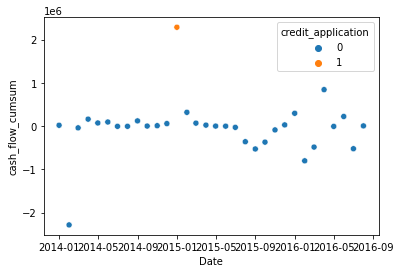

In [ ]:
sns.scatterplot(data=full[full['client_nr']==6], x="Date", y='cash_flow_cumsum',hue='credit_application')
plt.show()

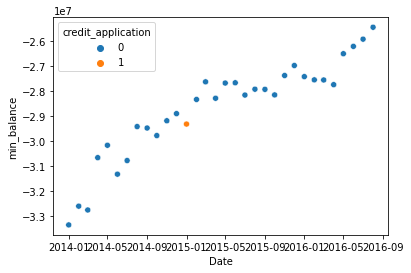

In [ ]:
sns.scatterplot(data=full[full['client_nr']==6], x="Date", y='min_balance',hue='credit_application')
plt.show()

client with 4 loans

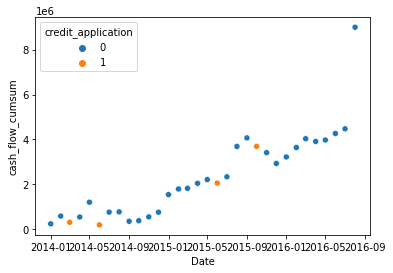

In [ ]:
sns.scatterplot(data=full[full['client_nr']==47], x="Date", y='cash_flow_cumsum',hue='credit_application')
plt.show()

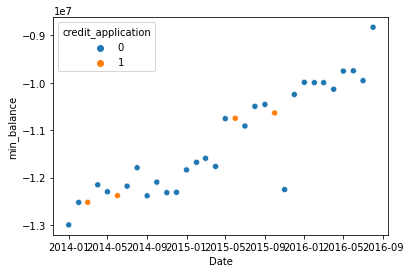

In [ ]:
sns.scatterplot(data=full[full['client_nr']==47], x="Date", y='min_balance',hue='credit_application')
plt.show()

one interesting pattern to see here is that the users who took more loans are the one for whome cash flow cumulative increase which means for whome income increase more.

In [ ]:
full[['T+1_nr_credit_applications',
       'T+2_nr_credit_applications', 'T+3_nr_credit_applications',
       'T+4_nr_credit_applications', 'T+5_nr_credit_applications',
       'T+6_nr_credit_applications', 'T+7_nr_credit_applications',
       'T+8_nr_credit_applications', 'T+9_nr_credit_applications',
       'T+10_nr_credit_applications', 'T+11_nr_credit_applications',
       'T+12_nr_credit_applications']]=full[['T+1_nr_credit_applications',
       'T+2_nr_credit_applications', 'T+3_nr_credit_applications',
       'T+4_nr_credit_applications', 'T+5_nr_credit_applications',
       'T+6_nr_credit_applications', 'T+7_nr_credit_applications',
       'T+8_nr_credit_applications', 'T+9_nr_credit_applications',
       'T+10_nr_credit_applications', 'T+11_nr_credit_applications',
       'T+12_nr_credit_applications']].fillna(0)

In [ ]:
full[['avg_local_credit','avg_local_debit','avg_global_credit','avg_global_debit']]=full[['avg_local_credit','avg_local_debit','avg_global_credit','avg_global_debit']].fillna(0)

In [ ]:
full.isna().sum()

client_nr                        0
total_nr_trx                     0
nr_debit_trx                     0
volume_debit_trx                 0
nr_credit_trx                    0
volume_credit_trx                0
min_balance                      0
max_balance                      0
CRG                              0
credit_application               0
nr_credit_applications           0
Date                             0
month                            0
cash_flow                        0
avg_local_credit                 0
avg_local_debit                  0
nr_credit_applications_cumsum    0
cash_flow_cumsum                 0
nr_debit_trx_cumsum              0
nr_credit_trx_cumsum             0
volume_debit_trx_cumsum          0
volume_credit_trx_cumsum         0
avg_global_credit                0
avg_global_debit                 0
global_min_balance               0
global_max_balance               0
T+1_nr_credit_applications       0
T+2_nr_credit_applications       0
T+3_nr_credit_applic

In [ ]:
full['CRG']=full['CRG'].astype(str)

instead of predicting number of exact loans at t+n timestep we instead use number of loans in next month, next 3 months, next 6 month and next 12 months for better predictibility.

In [ ]:
full['next_month_nr_credit_applications']=full['T+1_nr_credit_applications']

In [ ]:
full['next_3_month_nr_credit_applications']=full['T+1_nr_credit_applications']+full['T+2_nr_credit_applications']+full['T+3_nr_credit_applications']

In [ ]:
full['next_6_month_nr_credit_applications']=full['T+1_nr_credit_applications']+full['T+2_nr_credit_applications']+full['T+3_nr_credit_applications']+full['T+4_nr_credit_applications']+full['T+5_nr_credit_applications']+full['T+6_nr_credit_applications']

In [ ]:
full['next_12_month_nr_credit_applications']=full['T+1_nr_credit_applications']+full['T+2_nr_credit_applications']+full['T+3_nr_credit_applications']+full['T+4_nr_credit_applications']+full['T+5_nr_credit_applications']+full['T+6_nr_credit_applications']+full['T+7_nr_credit_applications']+full['T+8_nr_credit_applications']+full['T+9_nr_credit_applications']+full['T+10_nr_credit_applications']+full['T+11_nr_credit_applications']+full['T+12_nr_credit_applications']

In [ ]:
max(full['Date'])

Timestamp('2016-08-01 00:00:00')

to showcase the thought process we will predict for future 6 months.

In [ ]:
full=full[full['Date']<='2016-02-01']

In [ ]:
full.head()

,client_nr,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,...,T+7_nr_credit_applications,T+8_nr_credit_applications,T+9_nr_credit_applications,T+10_nr_credit_applications,T+11_nr_credit_applications,T+12_nr_credit_applications,next_month_nr_credit_applications,next_3_month_nr_credit_applications,next_6_month_nr_credit_applications,next_12_month_nr_credit_applications
0,1,97,50,6527929,47,7454863,-7914288,25110651,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,88,59,3475918,29,1895848,-8448513,25036651,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,96,62,31316405,34,20083583,-10347650,18020151,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,83,53,18669967,30,1091295,-15385039,13318200,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,94,54,2893905,40,2034075,-15682170,2350000,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X=full.drop(['T+1_nr_credit_applications','T+2_nr_credit_applications','T+3_nr_credit_applications','T+4_nr_credit_applications','T+5_nr_credit_applications','T+6_nr_credit_applications','T+7_nr_credit_applications','T+8_nr_credit_applications','T+9_nr_credit_applications','T+10_nr_credit_applications','T+11_nr_credit_applications','T+12_nr_credit_applications'],axis=1)

In [ ]:
X.columns

Index(['client_nr', 'total_nr_trx', 'nr_debit_trx', 'volume_debit_trx',
       'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance',
       'CRG', 'credit_application', 'nr_credit_applications', 'Date', 'month',
       'cash_flow', 'avg_local_credit', 'avg_local_debit',
       'nr_credit_applications_cumsum', 'cash_flow_cumsum',
       'nr_debit_trx_cumsum', 'nr_credit_trx_cumsum',
       'volume_debit_trx_cumsum', 'volume_credit_trx_cumsum',
       'avg_global_credit', 'avg_global_debit', 'global_min_balance',
       'global_max_balance', 'next_month_nr_credit_applications',
       'next_3_month_nr_credit_applications',
       'next_6_month_nr_credit_applications',
       'next_12_month_nr_credit_applications'],
      dtype='object')

In [ ]:
X=X.drop(columns=
            ['next_month_nr_credit_applications','next_3_month_nr_credit_applications','next_6_month_nr_credit_applications','next_12_month_nr_credit_applications','client_nr','Date','credit_application',
            'total_nr_trx','volume_debit_trx_cumsum','nr_credit_trx_cumsum'
            ],axis=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24370 entries, 0 to 29989
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nr_debit_trx                   24370 non-null  int64  
 1   volume_debit_trx               24370 non-null  int64  
 2   nr_credit_trx                  24370 non-null  int64  
 3   volume_credit_trx              24370 non-null  int64  
 4   min_balance                    24370 non-null  int64  
 5   max_balance                    24370 non-null  int64  
 6   CRG                            24370 non-null  object 
 7   nr_credit_applications         24370 non-null  int64  
 8   month                          24370 non-null  object 
 9   cash_flow                      24370 non-null  int64  
 10  avg_local_credit               24370 non-null  float64
 11  avg_local_debit                24370 non-null  float64
 12  nr_credit_applications_cumsum  24370 non-null 

we binarise the variable

In [ ]:
y=(full[['next_6_month_nr_credit_applications']]>=1).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

we create a train dataset, validation set ( for hyperparameter tuning) and a test set.

In [ ]:
X_val=X_train[-1000:]
y_val=y_train[-1000:]
X_train=X_train[:-1000]
y_train=y_train[:-1000]

# Modelling

In [ ]:
rf=RandomForestClassifier(n_estimators=500,max_depth=10,class_weight='balanced')
rf.fit(X_train,y_train)
%time
print(classification_report(y_test, rf.predict_proba(X_test)[:,1]>=0.5, target_names=["0","1"]))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1685
           1       0.61      0.79      0.69       752

    accuracy                           0.78      2437
   macro avg       0.75      0.78      0.76      2437
weighted avg       0.80      0.78      0.78      2437



above we casually fit a model lets see how much score we can improve with further hyperparameter tuning and ensembling.

In [ ]:
space_RF = {
    "n_estimators": hp.choice("n_estimators", [300, 400,500,600,700,800,900,1000]),
    "max_depth": hp.quniform("max_depth", 5, 15,1)
}

In [ ]:
def parameter_tuning_RF(params):
    clf = RandomForestClassifier(**params,class_weight='balanced',n_jobs=-1)
    f1 = cross_val_score(clf, X_train, y_train,scoring="f1_weighted",cv=3).mean()
    return {"loss": -f1, "status": STATUS_OK}

In [ ]:
trials = Trials()

best_RF = fmin(
    fn=parameter_tuning_RF,
    space = space_RF, 
    algo=tpe.suggest, 
    max_evals=30, 
    trials=trials
)

print("Best: {}".format(best_RF))

100%|██████████| 30/30 [27:21<00:00, 54.73s/it, best loss: -0.8248557350549816]
Best: {'max_depth': 15.0, 'n_estimators': 3}


In [ ]:
hyperparams = space_eval(space_RF,best_RF)

In [ ]:
hyperparams

{'max_depth': 15.0, 'n_estimators': 600}

we also perform feature selection and feature ranking.

In [ ]:
def feature_selector(clf,x,y):
  boruta = BorutaPy(estimator = clf, n_estimators = 'auto', max_iter = 50)
  boruta.fit(x.values, y.values)
  important = list(X.columns[boruta.support_])
  print(f"important: {important}")
  tentative = list(X.columns[boruta.support_weak_])
  print(f"unconfirmed: {tentative}")
  unimportant = list(X.columns[~(boruta.support_ | boruta.support_weak_)])
  print(f"unimportant: {unimportant}")
  important.extend(tentative)
  return important,boruta.ranking_

In [ ]:
clf=RandomForestClassifier(**hyperparams,class_weight='balanced',n_jobs=-1)

In [ ]:
featuresrf,ranking=feature_selector(clf,X_train,y_train)

important: ['nr_debit_trx', 'volume_debit_trx', 'nr_credit_trx', 'volume_credit_trx', 'min_balance', 'max_balance', 'CRG', 'avg_local_credit', 'avg_local_debit', 'nr_credit_applications_cumsum', 'cash_flow_cumsum', 'nr_debit_trx_cumsum', 'volume_credit_trx_cumsum', 'avg_global_credit', 'avg_global_debit', 'global_min_balance', 'global_max_balance']
unconfirmed: ['cash_flow']
unimportant: ['nr_credit_applications', 'month']


In [ ]:
X_train_rf=X_train.loc[:,featuresrf]
X_val_rf=X_val.loc[:,featuresrf]
X_test_rf=X_test.loc[:,featuresrf]

In [ ]:
clf=RandomForestClassifier(**hyperparams,class_weight='balanced',n_jobs=-1)

In [ ]:
clf.fit(X_train_rf,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15.0,
                       n_estimators=600, n_jobs=-1)

we also try to find the best threshold which will emphasise on the weighted f1 score.

In [ ]:
maxargrf=0.4
max_score=-1
for i in np.arange(0.4, 0.7, 0.01):
  score=f1_score(y_val, clf.predict_proba(X_val_rf)[:,1]>=i, average='weighted')
  if(score>max_score):
    max_score=score
    maxargrf=i

In [ ]:
maxargrf

0.5400000000000001

In [ ]:
%time
print(classification_report(y_test, clf.predict_proba(X_test_rf)[:,1]>=maxargrf, target_names=["0","1"]))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1685
           1       0.78      0.76      0.77       752

    accuracy                           0.86      2437
   macro avg       0.84      0.83      0.83      2437
weighted avg       0.86      0.86      0.86      2437



In [ ]:
len(y[y['next_6_month_nr_credit_applications']==1])

7523

In [ ]:
len(y[y['next_6_month_nr_credit_applications']==0])

16847

for catboost classifier we enable early stopping and scale pos parameter which takes care of imbalanced classes.

In [ ]:
clf2 = CatBoostClassifier(iterations=10000,
    learning_rate= 0.01,use_best_model=True,od_type='Iter',od_wait=50,scale_pos_weight=2.3)


In [ ]:
clf2.fit(
    X_train, y_train,
    cat_features=[6,8],
    plot=True,
    eval_set=(X_val ,y_val)
) 

In [ ]:
maxargcat=0.4
max_score=-1
for i in np.arange(0.4, 0.7, 0.01):
  score=f1_score(y_val, clf2.predict_proba(X_val)[:,1]>=i, average='weighted')
  if(score>max_score):
    max_score=score
    maxargcat=i

In [ ]:
%time
print(classification_report(y_test, clf2.predict(X_test), target_names=["0","1"]))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1685
           1       0.74      0.87      0.80       752

    accuracy                           0.86      2437
   macro avg       0.84      0.86      0.85      2437
weighted avg       0.87      0.86      0.87      2437



we optimise for a mix paramter which optimises the mix of random forest and catboost on validation set.

In [ ]:
scoree=-1
mix=0
for i in np.arange(0, 1, 0.1):
  j=1-i
  y_pred=(i*clf.predict_proba(X_val_rf)[:,1]+ j*(clf2.predict_proba(X_val)[:,1]))/(i+j)
  score=f1_score(y_val, (y_pred>=0.5).astype(int), average='weighted')
  if(score>scoree):
    scoree=score
    mix=i

In [ ]:
mix

0.30000000000000004

In [ ]:
y_pred=(mix*clf.predict_proba(X_test_rf)[:,1]+ (1-mix)*(clf2.predict_proba(X_test)[:,1]))

In [ ]:
%time
print(classification_report(y_test, (y_pred>=0.5).astype(int), target_names=["0","1"]))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1685
           1       0.75      0.87      0.80       752

    accuracy                           0.87      2437
   macro avg       0.84      0.87      0.85      2437
weighted avg       0.88      0.87      0.87      2437



so our model seems to be good just the precision is a bit less as compared to other metrics which can be optimised by raising the threshold as per business needs rest looks good.

# Result Analysis

In [ ]:
explainer = shap.TreeExplainer(clf2)
shap_values = explainer.shap_values(X_train) 

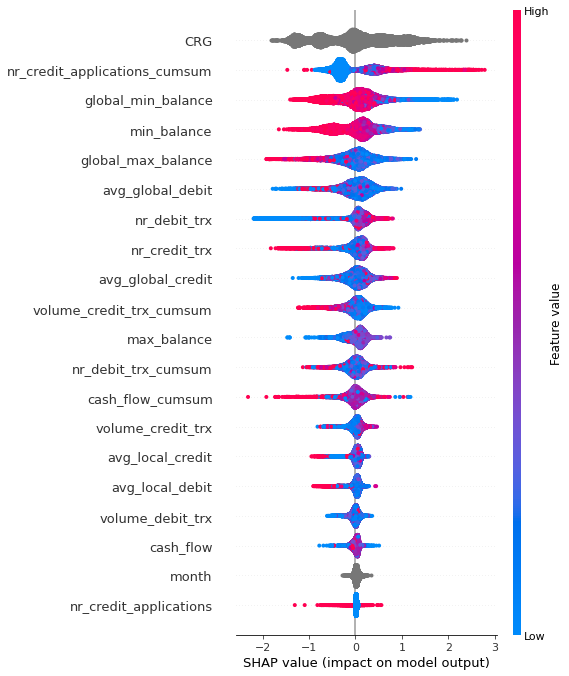

In [ ]:
shap.summary_plot(shap_values, X_train)

above shapley plot shows us that how variables affect the output. Its interesting to see the relationship of min/max balance, past credit applications on the output which seems to make sense.

for implementation we can rank the customers based on how high the probablity is to apply for a loans in the coming months, and give attention accordingly.

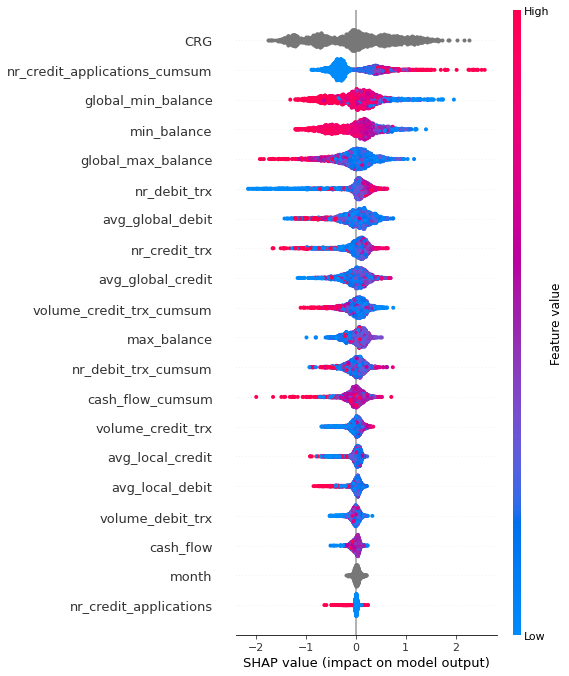

In [111]:
explainer = shap.TreeExplainer(clf2)
shap_values = explainer.shap_values(X_test) 
shap.summary_plot(shap_values, X_test)

In [175]:
type1=[] 
type2=[]

In [181]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [182]:
cm=confusion_matrix(y_test, (y_pred>=0.5).astype(int))

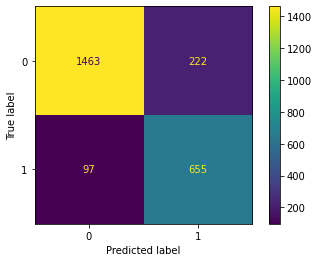

In [185]:
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf2.classes_).plot()

In [216]:
type2=[]

In [217]:
for p, a in zip(y_test.values.squeeze(), (y_pred>=0.5).astype(int)):
  if((p==0) & (a==1)):
    type2.append(True)
  else:
    type2.append(False)

In [203]:
X_test.loc[type2,:].describe()

,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,nr_credit_applications,cash_flow,avg_local_credit,avg_local_debit,nr_credit_applications_cumsum,cash_flow_cumsum,nr_debit_trx_cumsum,volume_credit_trx_cumsum,avg_global_credit,avg_global_debit,global_min_balance,global_max_balance
count,222.000000,2.220000e+02,222.000000,2.220000e+02,2.220000e+02,2.220000e+02,222.000000,2.220000e+02,222.000000,222.000000,222.000000,2.220000e+02,222.000000,2.220000e+02,222.000000,222.000000,2.220000e+02,2.220000e+02
mean,82.707207,8.441915e+06,74.828829,8.622403e+06,-8.890885e+06,-7.355832e+05,0.220721,1.804874e+05,123149.532152,104135.663538,2.139640,-7.015935e+05,1010.144144,1.100454e+08,125585.619152,108206.186392,-1.261369e+07,2.174478e+06
std,38.614932,6.607415e+06,56.483510,7.500837e+06,8.986808e+06,8.609833e+06,0.504212,3.455147e+06,94909.954476,72395.136775,2.405378,5.918188e+06,862.287869,1.156250e+08,75136.408686,70961.034486,1.395708e+07,1.120575e+07
min,14.000000,6.147450e+05,15.000000,9.090280e+05,-5.078090e+07,-4.457249e+07,0.000000,-6.689391e+06,28733.409836,12404.829787,0.000000,-3.749371e+07,29.000000,1.591174e+06,26002.477612,17515.647655,-7.685539e+07,-3.702260e+07
25%,51.250000,3.651970e+06,37.250000,3.671908e+06,-1.231199e+07,-3.946260e+06,0.000000,-6.404925e+05,69125.290164,56458.889923,0.000000,-1.532136e+06,342.250000,2.207029e+07,74317.129575,59643.994994,-1.535338e+07,-2.244168e+06
50%,73.500000,7.283650e+06,59.500000,6.851706e+06,-7.074746e+06,5.875950e+04,0.000000,7.080000e+03,102942.428150,78772.354288,1.500000,-2.734825e+05,771.000000,6.878834e+07,112778.034193,88494.956764,-9.051172e+06,8.519360e+05
75%,111.000000,1.138326e+07,95.000000,1.139022e+07,-3.187168e+06,1.479230e+06,0.000000,5.373035e+05,143889.871111,134017.040762,3.000000,5.858578e+05,1406.750000,1.528945e+08,145546.242877,141165.532783,-4.013094e+06,4.973174e+06
max,217.000000,4.332326e+07,414.000000,5.253854e+07,4.357142e+06,4.048669e+07,3.000000,4.358051e+07,929674.941176,378763.500000,15.000000,4.263622e+07,4328.000000,5.971536e+08,504657.909091,425501.725962,5.007770e+05,5.993425e+07


In [218]:
correct_labe1=[]
for p, a in zip(y_test.values.squeeze(), (y_pred>=0.5).astype(int)):
  if((p==0) & (a==0)):
    correct_labe1.append(True)
  else:
    correct_labe1.append(False)

In [219]:
X_test.loc[correct_labe1,:].describe()[['cash_flow_cumsum','min_balance']]

,cash_flow_cumsum,min_balance
count,1.463000e+03,1.463000e+03
mean,-2.712885e+05,-3.102227e+06
std,1.504404e+07,1.337984e+07
min,-3.400017e+08,-2.512930e+08
25%,-2.483418e+06,-5.124114e+06
50%,-6.646800e+04,-3.054610e+05
75%,1.921716e+06,1.480795e+05
max,1.272466e+08,1.551133e+08


In [220]:
X_test.loc[type2,:].describe()[['cash_flow_cumsum','min_balance']]

,cash_flow_cumsum,min_balance
count,2.220000e+02,2.220000e+02
mean,-7.015935e+05,-8.890885e+06
std,5.918188e+06,8.986808e+06
min,-3.749371e+07,-5.078090e+07
25%,-1.532136e+06,-1.231199e+07
50%,-2.734825e+05,-7.074746e+06
75%,5.858578e+05,-3.187168e+06
max,4.263622e+07,4.357142e+06


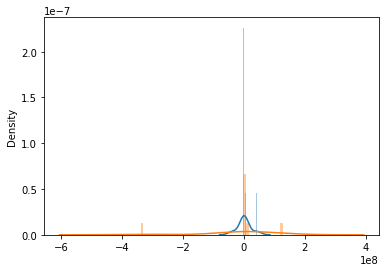

In [212]:
sns.distplot(X_test.loc[type2,:].describe()[['cash_flow_cumsum']])
sns.distplot(X_test.loc[correct_labe1,:].describe()[['cash_flow_cumsum']])


we can see that one possible reason for misclassification (type2) error is that in the test set it was difficult to predict correctly for some examples since distribution of cash_flow_cumsum, min_balance was very wide which kind of hints they were tricky to classify. We can similarly check for other dimensions to inspect why some types of error occured.

In [ ]:
#joblib.dump(clf, 'rf_model.sav')

In [ ]:
#clf2.save_model('catboost_model.dump')